<a href="https://colab.research.google.com/github/yeb2Binfang/ECE-9123_DL/blob/main/HW/HW1/hw1prob4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

OK, thus far we have been talking about linear models. All these can be viewed as a single-layer neural net. The next step is to move on to multi-layer nets. Training these is a bit more involved, and implementing from scratch requires time and effort. Instead, we just use well-established libraries. I prefer PyTorch, which is based on an earlier library called Torch (designed for training neural nets via backprop).

##Import packages

In [1]:
import numpy as np
import torch
import torchvision

##Try pytorch
Torch handles data types a bit differently. Everything in torch is a *tensor*.

Randomly generate a, a is an array and when we use torch.from_numpy which will let a become a tensor

In [2]:
a = np.random.rand(2,3)
b = torch.from_numpy(a)

# Q4.1 Display the contents of a, b
# ...
# ...
print("a:")
print(a)
print()
print("b:")
print(b)

a:
[[0.30435482 0.61588698 0.41877524]
 [0.05174126 0.26479272 0.58359857]]

b:
tensor([[0.3044, 0.6159, 0.4188],
        [0.0517, 0.2648, 0.5836]], dtype=torch.float64)


The idea in Torch is that tensors allow for easy forward (function evaluations) and backward (gradient) passes.

Here, we need to understand the requires_grad. 
If there’s a single input to an operation that requires gradient, its output will also require gradient. Conversely, only if all inputs don’t require gradient, the output also won’t require it. 
So, if the input has requires_grad=True, then the output also has require gradient. 
Backward computation will not happen when all tensors do not require gradient.

In [3]:
A = torch.rand(2,2)
b = torch.rand(2,1)
x = torch.rand(2,1, requires_grad=True)

y = torch.matmul(A,x) + b

print(A)
print(b)
print(x)

print(y)

z = y.sum()
print(z)
z.backward()
print(x.grad)
print(x)

tensor([[0.7209, 0.4897],
        [0.8969, 0.5733]])
tensor([[0.6203],
        [0.2386]])
tensor([[0.6009],
        [0.9437]], requires_grad=True)
tensor([[1.5156],
        [1.3186]], grad_fn=<AddBackward0>)
tensor(2.8342, grad_fn=<SumBackward0>)
tensor([[1.6178],
        [1.0630]])
tensor([[0.6009],
        [0.9437]], requires_grad=True)


##download data
Notice how the backward pass computed the gradients using autograd. OK, enough background. Time to train some networks. Let us load the *Fashion MNIST* dataset, which is a database of grayscale images of clothing items.


In [4]:
trainingdata = torchvision.datasets.FashionMNIST('./FashionMNIST/',train=True,download=True,transform=torchvision.transforms.ToTensor())
testdata = torchvision.datasets.FashionMNIST('./FashionMNIST/',train=False,download=True,transform=torchvision.transforms.ToTensor())


Extracting ./FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/FashionMNIST/raw


Extracting ./FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/FashionMNIST/raw



Extracting ./FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/FashionMNIST/raw


Extracting ./FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/FashionMNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


##Explore data
Let us examine the size of the dataset.
When we print it out, we can see it should have 28*28 features in each data point

In [5]:
# Q4.2 How many training and testing data points are there in the dataset? 
# What is the number of features in each data point?
# ...
# ...
print(trainingdata)
print(testdata)
print(trainingdata.targets.shape)

print(trainingdata.data.shape)

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./FashionMNIST/
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: ./FashionMNIST/
    Split: Test
    StandardTransform
Transform: ToTensor()
torch.Size([60000])
torch.Size([60000, 28, 28])


Let us try to visualize some of the images. Since each data point is a tensor (not an array) we need to postprocess to use matplotlib.

9


/usr/local/lib/python3.6/dist-packages/torch/tensor.py:447: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


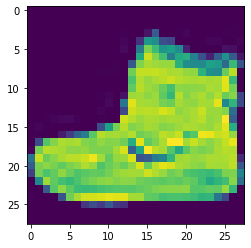

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

image, label = trainingdata[0]
# Q4.3 Assuming each sample is an image of size 28x28, show it in matplotlib.
# ...
# ...
print(label)
plt.imshow(image.resize(28,28))

Let's try plotting several images. This is conveniently achieved in PyTorch using a *data loader*, which loads data in batches. We will get 64 data points every data. It will be easy to compute later. For traindata, it will shuffle every time.

In [7]:
trainDataLoader = torch.utils.data.DataLoader(trainingdata, batch_size=64, shuffle=True,)
testDataLoader = torch.utils.data.DataLoader(testdata, batch_size=64, shuffle=False)
images, labels = iter(trainDataLoader).next()
print(images.size(), labels)

torch.Size([64, 1, 28, 28]) tensor([6, 6, 3, 7, 7, 4, 6, 4, 2, 3, 8, 8, 9, 2, 5, 7, 2, 6, 2, 4, 2, 6, 9, 5,
        1, 9, 0, 5, 6, 4, 5, 5, 3, 1, 2, 5, 7, 1, 4, 9, 6, 8, 7, 0, 1, 6, 4, 6,
        3, 1, 6, 7, 5, 5, 8, 6, 6, 2, 6, 9, 6, 2, 8, 1])


In [8]:
print(image.shape)

torch.Size([1, 28, 28])


Get image data from testDataLoader, we ploted first 10 images and we used subplot to organize it.

/usr/local/lib/python3.6/dist-packages/torch/tensor.py:447: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


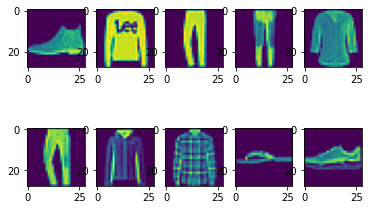

In [28]:
# Q4.4 Visualize the first 10 images of the first minibatch 
# returned by testDataLoader.
# ...
# ...
test_images, test_labels = iter(testDataLoader).next()
for i in range(0,10):
  plt.subplot(2,5,i+1)
  plt.imshow(test_images[i].resize(28,28))
  

##Define linear model
Now we are ready to define our linear model. Here is some boilerplate PyTorch code that implements the forward model for a single layer network for logistic regression (similar to the one discussed in class notes). 

In [63]:
class LinearReg(torch.nn.Module):
  def __init__(self):
    super(LinearReg, self).__init__()
    self.linear = torch.nn.Linear(28*28,10)

  def forward(self, x):
    x = x.view(-1,28*28)
    transformed_x = self.linear(x)
    return transformed_x

net = LinearReg().cuda()
Loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)



###train network
Cool! Now we have set everything up. Let's try to train the network. We will train the network defined above. We will calculate the average loss every epoch fro training data and test data.

In [64]:
train_loss_history = []
test_loss_history = []

# Q4.5 Write down a for-loop that trains this network for 20 epochs, 
# and print the train/test losses.
# Save them in the variables above. If done correctly, you should be able to 
# execute the next code block.
# ...
# ...

for epoch in range(20):
    tr_loss_list = []
    ts_loss_list = []
    for i, data in enumerate(trainDataLoader,0):
      tr_inputs, tr_labels = data
      optimizer.zero_grad()

      outputs = net(tr_inputs.cuda())
      loss = Loss(outputs,tr_labels.cuda())
      loss.backward()
      optimizer.step()
      tr_loss_list.append(loss.item())
      #print(tr_loss_list)
    tr_loss_avg = sum(tr_loss_list)/len(tr_loss_list)
    train_loss_history.append(tr_loss_avg)

    for i, data in enumerate(testDataLoader,0):
      ts_inputs, ts_labels = data
      optimizer.zero_grad()

      outputs = net(ts_inputs.cuda())
      loss = Loss(outputs,ts_labels.cuda())
      loss.backward()
      optimizer.step()
      ts_loss_list.append(loss.item())
    
    ts_loss_avg = sum(ts_loss_list)/len(ts_loss_list)
    test_loss_history.append(ts_loss_avg)




In [65]:
print(train_loss_history)
print(test_loss_history)

[0.9559048773891636, 0.6520971681898845, 0.5895328064526576, 0.5561908759605656, 0.534356366819156, 0.518594569282364, 0.5066140257695845, 0.4967358976380149, 0.488948988889072, 0.4823232078666626, 0.476543611697932, 0.4714552985547956, 0.4669887301351216, 0.4630397442084894, 0.45953303435718074, 0.4560927975374752, 0.45356855539879054, 0.45060515999476286, 0.4483562582559677, 0.4458102614704226]
[0.7253690883991825, 0.6322184330338885, 0.590196823997862, 0.56479350244923, 0.5474471246740621, 0.5343411177586598, 0.5241817541562828, 0.5157720095412747, 0.5086852513301144, 0.5028613154675551, 0.4977691970813047, 0.49323121624387756, 0.4892176292884122, 0.4855759229250015, 0.4823743057478765, 0.47942543940938964, 0.47655942011031377, 0.4741489731582107, 0.4717995723721328, 0.46964121443830475]


In [22]:
print(labels)

tensor([6, 6, 3, 7, 7, 4, 6, 4, 2, 3, 8, 8, 9, 2, 5, 7, 2, 6, 2, 4, 2, 6, 9, 5,
        1, 9, 0, 5, 6, 4, 5, 5, 3, 1, 2, 5, 7, 1, 4, 9, 6, 8, 7, 0, 1, 6, 4, 6,
        3, 1, 6, 7, 5, 5, 8, 6, 6, 2, 6, 9, 6, 2, 8, 1])


plot the loss graph

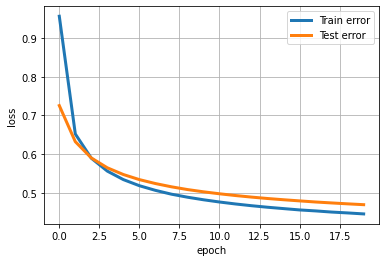

In [66]:
plt.plot(range(20),train_loss_history,'-',linewidth=3,label='Train error')
plt.plot(range(20),test_loss_history,'-',linewidth=3,label='Test error')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

Neat! Now let's evaluate our model accuracy on the entire dataset. The predicted class label for a given input image can computed by looking at the output of the neural network model and computing the index corresponding to the maximum activation. Something like

*predicted_output = net(images)*
*_, predicted_labels = torch.max(predicted_output,1)*

In [67]:
predicted_output = net(images.cuda())
print(torch.max(predicted_output, 1))
fit = Loss(predicted_output, labels.cuda())
print(labels)

torch.return_types.max(
values=tensor([ 7.6511,  6.3200,  3.5632,  5.3376,  8.6754,  7.3957,  5.1442,  7.0970,
         7.0676,  6.8849, 10.9263,  4.4119,  7.8901,  7.0190,  7.9354, 10.3466,
         5.3248,  8.9616,  9.7062,  8.1918,  5.0854,  6.7332, 11.9416,  4.4883,
        12.4314,  6.5984,  6.0975,  4.9972,  6.7973,  8.5018,  5.5331,  7.9429,
         7.0852,  6.2794,  6.0893,  7.5056,  5.3275, 10.5116,  3.3444, 12.8705,
         5.3625,  5.4589,  8.5068, 12.9813, 11.0359,  4.2591,  5.7748,  3.3948,
         5.8395, 13.1109,  7.1317,  7.8050,  6.7632,  5.5268,  4.7925,  8.4738,
         5.5584,  8.0022,  5.7146, 12.0763,  5.2627,  5.7551,  3.3652, 11.4393],
       device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor([6, 6, 3, 7, 7, 6, 6, 4, 2, 3, 8, 8, 5, 2, 5, 7, 4, 6, 2, 4, 6, 6, 9, 5,
        1, 9, 0, 5, 6, 4, 5, 5, 3, 1, 2, 9, 7, 1, 4, 9, 6, 8, 7, 0, 1, 6, 4, 6,
        3, 1, 4, 7, 5, 5, 8, 2, 6, 2, 6, 9, 6, 2, 8, 1], device='cuda:0'))
tensor([6, 6, 3, 7, 7, 4, 6, 4, 2, 3

In [73]:
print(fit)

tensor(0.4271, device='cuda:0', grad_fn=<NllLossBackward>)


In [72]:
print((torch.max(predicted_output, 1)[1]==labels.cuda()).float().sum()/labels.shape[0])

tensor(0.8906, device='cuda:0')


##Test on the dataset
We will use the model we trained before to test the whole dataset and see the accuracy.

In [80]:
def evaluate(dataloader):
  # Q4.6 Implement a function here that evaluates training and testing accuracy.
  # Here, accuracy is measured by probability of successful classification.
  # ...
  # ...
  input, label = iter(dataloader).next()
  pred = net(input.cuda())
  acc = (torch.max(pred,1)[1]==label.cuda()).float().sum()/label.shape[0]
  return acc

print('Train acc = %0.2f, test acc = %0.2f' % (evaluate(trainDataLoader), evaluate(testDataLoader)))

Train acc = 0.83, test acc = 0.83


Finally, we get the accuracies for training data and testing data are 83% and 83% respectively. It is not a pretty good result